In [47]:
import os
from params.paths import ROOT_DIR, CHROMEDRIVER_PATH
from file_handling.file_read_writer import read_json, write_json, create_dir, write_file
from data_process.string_processor import StringProcessor
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np

In [48]:
# params and paths
DATA_DIR = os.path.join(ROOT_DIR, 'data_prepping', 'data')
SPEECHES_DIR = os.path.join(DATA_DIR, 'data_repr')

# Testing out mecab and unidic

In [49]:
sp = StringProcessor()
split_string_words, extra = sp.divide_string("生国務大臣　一九五一年、朝鮮事変勃発、そのときにこの日米安保条約というのは結ばれたのが最初だと思いますが、そのときに、サンフランシスコの講和条約、まあ、あのころみんながちゃがちゃと始まったんですけれども。\r\n　記憶にあるのは、あのときは、単独講和か全面講和かという言葉がえらく新聞に躍っていましたけれども、日本の加盟に賛成したのは四十三カ国が単独で、反対したのはソ連、ポーランド、ハンガリーだったかな、その三カ国は反対ということで、これは、四十三対三だったら、単独講和じゃなくて多数講和か全面講和かの違いなんじゃないのと、子供心にそう思った記憶がありますけれども。\r\n　あの時代から七十年近くがたちまして、今は、米ソ冷戦というのは、三十年前、八九年に終わっております。ベルリンの壁崩壊とともに終わっておりますので。\r\n　今は、新たに、米中みたいな形になってきて、間違いなく、日本の周辺水域や何かにおいても、北の守りよりは、むしろ、我々の方の南のところで、南シナ海の話とか東シナ海の話とか北朝鮮の話になってきて、状況は随分変わってきたと思いますが、この日米安全保障条約というものが日本の防衛、安保、外交等々の中において非常に大きな役割を果たしておりますので、今後ともこの日米安全保障条約というものが日本の防衛、外交上極めて重要なものであり続けるであろうというのは、この間の六十周年に行って、改めてそう感じたところです")
print(split_string_words)
print(extra)
to_df = pd.DataFrame({"word": split_string_words, "extra": extra})
to_df.to_csv("test.csv", index=False)
print(Counter(split_string_words)+Counter(split_string_words))

['生', '国務', '大臣', '\u3000', '一', '九', '五', '一', '年', '、', '朝鮮', '事変', '勃発', '、', 'その', 'とき', 'に', 'この', '日米', '安保', '条約', 'と', 'いう', 'の', 'は', '結ば', 'れ', 'た', 'の', 'が', '最初', 'だ', 'と', '思い', 'ます', 'が', '、', 'その', 'とき', 'に', '、', 'サンフランシスコ', 'の', '講和', '条約', '、', 'まあ', '、', 'あの', 'ころ', 'みんな', 'がちゃがちゃ', 'と', '始まっ', 'た', 'ん', 'です', 'けれど', 'も', '。', '\r', '\u3000', '記憶', 'に', 'ある', 'の', 'は', '、', 'あの', 'とき', 'は', '、', '単独', '講和', 'か', '全面', '講和', 'か', 'と', 'いう', '言葉', 'が', 'えらく', '新聞', 'に', '躍っ', 'て', 'い', 'まし', 'た', 'けれど', 'も', '、', '日本', 'の', '加盟', 'に', '賛成', 'し', 'た', 'の', 'は', '四十', '三', 'カ国', 'が', '単独', 'で', '、', '反対', 'し', 'た', 'の', 'は', 'ソ連', '、', 'ポーランド', '、', 'ハンガリー', 'だっ', 'た', 'か', 'な', '、', 'その', '三', 'カ国', 'は', '反対', 'と', 'いう', 'こと', 'で', '、', 'これ', 'は', '、', '四十', '三', '対', '三', 'だっ', 'たら', '、', '単独', '講和', 'じゃ', 'なく', 'て', '多数', '講和', 'か', '全面', '講和', 'か', 'の', '違い', 'な', 'ん', 'じゃ', 'ない', 'の', 'と', '、', '子供', '心', 'に', 'そう', '思っ', 'た', '記憶', 'が', 'あり', 'ます', 'けれど', 'も', '。',

## Seeing whether there is value to be gained from counting the words in the speeches

In [50]:
defence_speech_dir = os.path.join(SPEECHES_DIR, '安全保障・安保・防衛')
asuo_file = os.path.join(defence_speech_dir, 'asuo_tarou.json') 
asuo_json = read_json(asuo_file)
speeches = asuo_json['speechRecord']
asuo_counting = Counter()
exclusions = ['助動詞', '補助記号','助詞','空白','連体詞','動詞']
for speech in speeches:
    speech_string = speech['speech']
    split_string, extra = sp.divide_string(speech_string, exclusions)
    
    # print(extra)
    counted = Counter(split_string)
    asuo_counting += counted

# print(asuo_counting)
# print(sorted(asuo_counting.items(), key=lambda x: x[1], reverse=True)[:10])
asuo_df = pd.DataFrame(sorted(asuo_counting.items(), key=lambda x: x[1], reverse=True), columns=['word', 'count'])
asuo_df.to_csv(os.path.join(defence_speech_dir, 'asuo_counting.csv'), index=False)

# Using bert models to embed the speeches

In [51]:
import torch
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


In [52]:
model_name = "cl-tohoku/bert-base-japanese"
bert_model_jp = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
# testing tokenizer and model
example_sentence = "朝鮮事変勃発、そのときにこの日米安保条約というのは結ばれたのが最初だと思いますが、そのときに、サンフランシスコの講和条約、まあ、あのころみんながちゃがちゃと始まったんですけれども。\r\n　記憶にあるのは、あのときは、単独講和か全面講和かという言葉がえらく新聞に躍っていましたけれども、日本の加盟に賛成したのは四十三カ国が単独で、反対したのはソ連、ポーランド、ハンガリーだったかな、その三カ国は反対ということで、これは、四十三対三だったら、単独講和じゃなくて多数講和か全面講和かの違いなんじゃないのと、子供心にそう思った記憶がありますけれども。"
encoded = tokenizer(example_sentence, return_tensors="pt")
print('encoded shape', encoded['input_ids'][0].shape)
print(tokenizer.decode(encoded['input_ids'][0]))
embedded = bert_model_jp(**encoded)
print(embedded.last_hidden_state.shape)

encoded shape torch.Size([170])
[CLS] 朝鮮 事変 勃発 、 その とき に この 日 米 安保 条約 という の は 結ば れ た の が 最初 だ と 思い ます が 、 その とき に 、 サンフランシスコ の 講和 条約 、 まあ 、 あの ころ みんな がちゃがちゃ と 始まっ た ん です けれども 。 記憶 に ある の は 、 あの とき は 、 単独 講和 か 全面 講和 か という 言葉 が えらく 新聞 に 躍っ て い まし た けれども 、 日本 の 加盟 に 賛成 し た の は 四 十 三 カ国 が 単独 で 、 反対 し た の は ソ連 、 ポーランド 、 ハンガリー だっ た か な 、 その 三 カ国 は 反対 という こと で 、 これ は 、 四 十 三 対 三 だっ たら 、 単独 講和 じゃ なく て 多数 講和 か 全面 講和 か の 違い な ん じゃ ない の と 、 子供 心 に そう 思っ た 記憶 が あり ます けれども 。 [SEP]
torch.Size([1, 170, 768])


In [54]:
#testing sentence transformer
from sentence_transformers import SentenceTransformer
sentence_transformer = SentenceTransformer(model_name)
sentence_embedding = sentence_transformer.encode(example_sentence)
print('sentence embedding shape', sentence_embedding.shape)

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/cl-tohoku_bert-base-japanese. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/cl-tohoku_bert-base-japanese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificatio

sentence embedding shape (768,)


In [55]:
embedded_texts = []
for topic_dir in os.listdir(SPEECHES_DIR):
    print(topic_dir)
    dir_path = os.path.join(SPEECHES_DIR, topic_dir)
    files = os.listdir(dir_path)
    for file in files:
        if not file.endswith('json'):
            continue
        file_path = os.path.join(dir_path, file)
        json_obj = read_json(file_path)
        speeches = json_obj['speechRecord']
        speech_cocat = ''
        for speech in speeches:
            speech_string = speech['speech']
            speech_cocat += speech_string
        print('speech length of file', file, len(speech_cocat))
        embedded = sentence_transformer.encode(speech_cocat)
        embedded_texts.append(embedded)

エネルギー・原発・原子力
speech length of file shii_kazuo.json 18384
speech length of file asuo_tarou.json 1213
speech length of file izumi_kenta.json 18223
speech length of file tamaki_yuichiro.json 15482
安全保障・安保・防衛
speech length of file shii_kazuo.json 25586
speech length of file asuo_tarou.json 93950
speech length of file izumi_kenta.json 17948
speech length of file tamaki_yuichiro.json 27873


(8, 2)


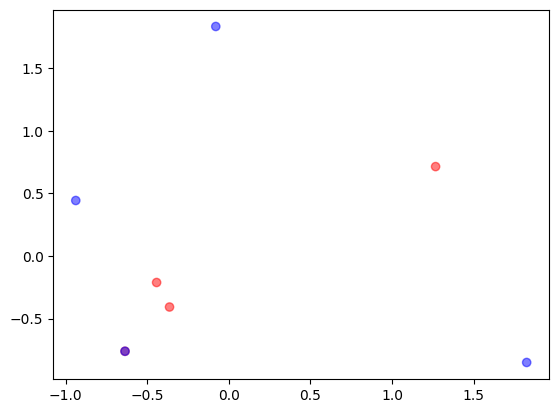

In [58]:
# doing PCA decomposition and plotting

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
embedded_texts = np.array(embedded_texts)
pca = PCA(n_components=2)
pca.fit(embedded_texts)
pca_transformed = pca.transform(embedded_texts)
xs = pca_transformed[:,0]
ys = pca_transformed[:,1]
print(pca_transformed.shape)
plt.scatter(xs, ys, alpha=0.5, color=['red' for _ in range(4)] + ['blue' for _ in range(4)])
